## Look at gradient embeddings of PPI-CMs 
(currrently all done in parcel space, ind. fit with `fit_ppi_cms.py`)

current confusion: `seedTS` yields very weird GMs, `seedTS:psy_context1` very nice ones (DMN=anchor)
maybe order swapped somehow? 

--> look in individuals... etc. --> `ppiConnMatrices.ipynb`

In [2]:
from nilearn.connectome import ConnectivityMeasure
from brainspace.utils.parcellation import reduce_by_labels
import numpy as np
import os.path as op
#from numrisk.fmri_analysis.gradients.utils_old import get_events_confounds
import seaborn as sns
import pandas as pd

import nilearn.plotting as nplt
import matplotlib.pyplot as plt

bids_folder = '/mnt_03/ds-dnumrisk' 

# Get Glasser parcellation and mask
from numrisk.fmri_analysis.gradients.utils import get_glasser_CAatlas_mapping, get_glasser_parcels
glasser_CAatlas_mapping, CAatlas_names = get_glasser_CAatlas_mapping()
mask_glasser, labeling_glasser = get_glasser_parcels(space = 'fsaverage5' )

from brainspace.utils.parcellation import map_to_labels
from nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage()

In [3]:
regressors_names = ['seedTS', 'psy_context1', 'psy_context2', 'seedTS:psy_context1', 'seedTS:psy_context2']
param = 'seedTS'
regressors_names.index(param)

0

In [43]:
param = 'seedTS'#'psy_context2' # :psy_context1
N_parcels = 360
av_cm = np.zeros((N_parcels, N_parcels))
count_cm = np.zeros((N_parcels, N_parcels))  # To count valid (non-NaN) entries

N_subs = 66

for sub in range(1,N_subs+1):
    sub = f'{sub:02d}'

    source_folder = op.join(bids_folder,'derivatives','correlation_matrices')
    fn = op.join(source_folder, f'sub-{sub}_PPI-allParamsMatrices.npy')

    ppi_cms_ = np.load(fn)
    av_cm += ppi_cms_[regressors_names.index(param)]  

av_cm = av_cm/N_subs
av_cm_transf = np.tan(av_cm)  # 119 problem & 171 ?
sub = 'All'

### Option 1 to deal with NaNs in matrix:  
 remove NaNs from the average matrix, and add them later at the specific position in the resulting gradiens (from gradients/networkDispersion_01.ipynb)



In [72]:
nodes_to_remove = [119, 171] # identofied with:
# np.where(np.isnan(av_cm_transf).all(axis=1))    
# n_start = 100, n_stop = 180
#plt.imshow(av_cm_transf[n_start:n_stop][:,n_start:n_stop]) 

# Create a mask for rows and columns to keep
mask = np.ones(av_cm_transf.shape[0], dtype=bool)
mask[nodes_to_remove] = False

# Use the mask to index the matrix and remove the specified rows and columns
cleaned_matrix = av_cm_transf[mask][:, mask]
cleaned_matrix[np.abs(cleaned_matrix)>30] = 0 # weird extrem values (for param=seedTS)

def restore_shape(filtered_result, original_mask):
    result_full = np.full((original_mask.shape[0], filtered_result.shape[1]), np.nan)
    result_full[original_mask] = filtered_result
    return result_full

<Axes: >

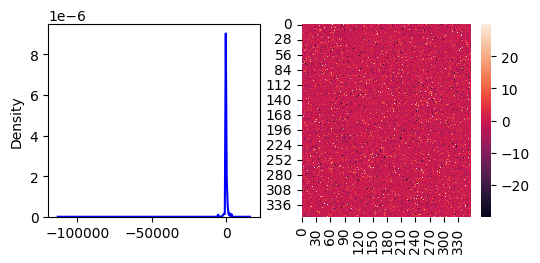

In [ ]:
# check data {only 1 connected_componet, is not the problem!}
fg,ax = plt.subplots(1,2, figsize=(6,2.5))
sns.kdeplot(av_cm_transf.flatten(), ax=ax[0], color='blue', label='All')
sns.heatmap(cleaned_matrix, ax=ax[1])

In [86]:
cm = cleaned_matrix # av_cm_transf #ppi_cms[param]

kernel = 'normalized_angle' # None #
n_components = 10
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import reduce_by_labels, map_to_labels
gm = GradientMaps(n_components=n_components, kernel = kernel, approach='dm',random_state=0)
gm.fit(cm)

gradients_ = restore_shape(gm.gradients_, mask) # Option 1 to deal with NaNs in matrix

grad = [None] * n_components
for i, g in enumerate(gradients_.T):
    grad[i] = map_to_labels(g, labeling_glasser, mask=mask_glasser, fill=np.nan)
print('gradients generated')


gradients generated


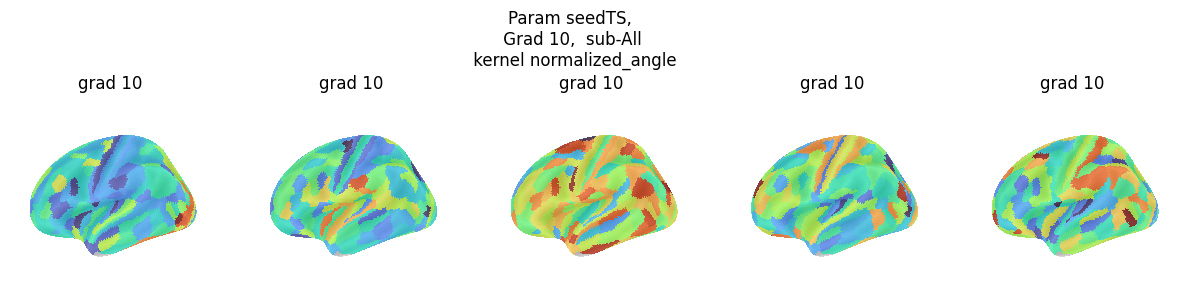

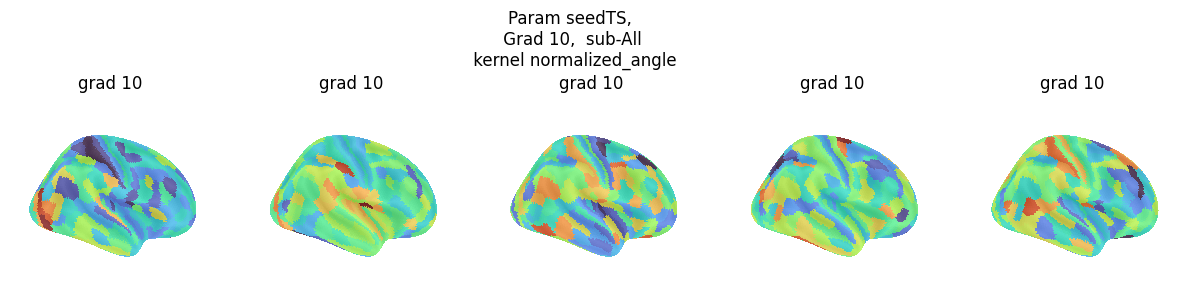

In [87]:
n_comp = 5
for i_hemi, hemi in enumerate(['L','R']):
    figure, axes = plt.subplots(nrows=1, ncols=n_comp,figsize = (15,8), subplot_kw=dict(projection='3d'))

    surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
    bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left
    side_view = 'medial' if hemi =='R' else 'lateral'

    for i_comp in range(0,n_comp):
        n_grad= i+1
        gm_ = np.split(grad[i_comp],2)[i_hemi] # for i, hemi in enumerate(['L', 'R']): --> left first
        nplt.plot_surf(surf_mesh= surf_mesh, surf_map= gm_,avg_method="median", # infl_right # pial_right
                    view= side_view,cmap=cmap, colorbar=False,  # sub-{sub}, title=f'grad {i+1}',
                    bg_map=bg_map, bg_on_data=True,darkness=0.7 ,axes=axes[i_comp]) #
        axes[i_comp].set(title=f'grad {n_grad}')
    figure.suptitle(f'Param {param}, \n Grad {n_grad},  sub-{sub} \n kernel {kernel}',y = 0.73 )

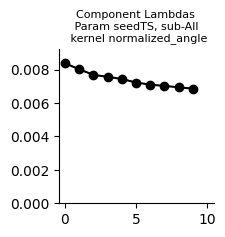

In [88]:
vals = gm.lambdas_
fug, ax = plt.subplots(1,1, figsize=(2,2))
ax.plot(vals, marker='o', mfc='k', mec='k', linestyle='-', color='k')
ax.set(ylim=[0, np.max(vals) + np.max(vals) * 0.1],xlim=[-0.4,10.5] )
ax.set_title(f'Component Lambdas \n Param {param}, sub-{sub} \n kernel {kernel}', fontsize=8)
sns.despine(ax=ax)

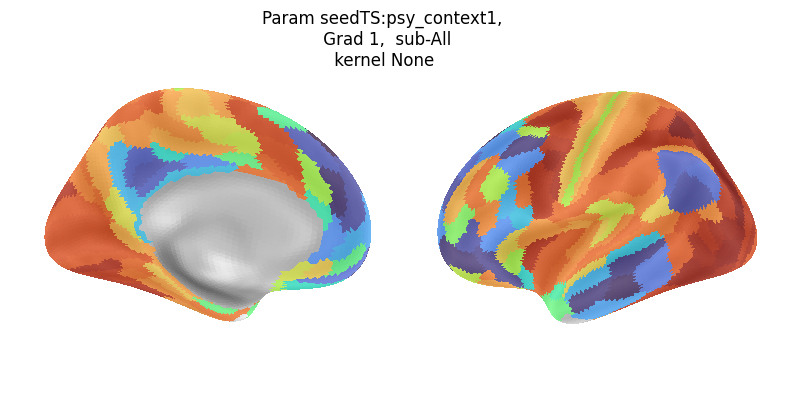

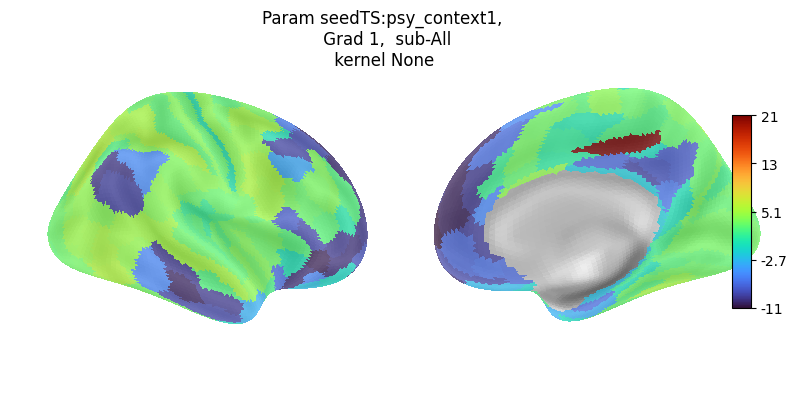

In [38]:
n_grad = 1
gradient = grad[n_grad-1]

cmap = 'turbo'
views = ['medial','lateral']
for i, hemi in enumerate(['L','R']):
    map = np.split(gradient,2)[i]
    surf_mesh = fsaverage.infl_right if hemi =='R' else fsaverage.infl_left
    bg_map = fsaverage.sulc_right if hemi =='R' else fsaverage.sulc_left

    figure, axes = plt.subplots(nrows=1, ncols=len(views),figsize = (10,5), subplot_kw=dict(projection='3d'))
    for i,view in enumerate(views):
        colbar = True if view == 'lateral' and hemi == 'R' else False
        nplt.plot_surf(surf_mesh=surf_mesh , surf_map= map,avg_method="median", #interpolation="nearest" ,# infl_right # pial_right
                view= view,cmap=cmap, colorbar=colbar, #title=f'sub-{sub}, grad {n_grad+1}',
                bg_map=bg_map, bg_on_data=True,darkness=0.7, axes=axes[i]) 
    figure.subplots_adjust(wspace=0.01)
    figure.suptitle(f'Param {param}, \n Grad {n_grad},  sub-{sub}\n kernel {kernel} ', y=0.9)

### Option2 deal with NaNs: exlude NaNs from single subject matrices

(think give pretty similar results!)


In [ ]:

# to loop:
    cm = ppi_cms_[regressors_names.index(param)]  # 0 -- param='seedTS'
    valid_mask = ~np.isnan(cm)
    count_cm[valid_mask] += 1
    av_cm[valid_mask] += cm[valid_mask]

# 
cm =  av_cm_transf #ppi_cms[param]

kernel = 'normalized_angle'
n_components = 10
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import reduce_by_labels, map_to_labels
gm = GradientMaps(n_components=n_components, kernel = kernel, approach='dm',random_state=0)
gm.fit(cm)

grad = [None] * n_components
for i, g in enumerate(gm.gradients_.T):
    grad[i] = map_to_labels(g, labeling_glasser, mask=mask_glasser, fill=np.nan)
print('gradients generated')